In [1]:
import sys
sys.path.append('../')

from cogsci2017.environment.arm_diva_env import CogSci2017Environment
from cogsci2017.learning.supervisor import Supervisor
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

iterations = 2000

environment = CogSci2017Environment(gui=False, audio=False)


config = dict(m_mins=environment.conf.m_mins,
             m_maxs=environment.conf.m_maxs,
             s_mins=environment.conf.s_mins,
             s_maxs=environment.conf.s_maxs)

agent = Supervisor(config, model_babbling="random", n_motor_babbling=1000, explo_noise=0.05)



human sounds ['eyu', 'iuo', 'yeo', 'uye', 'oey', 'eou']


Iteration 0


../cogsci2017/environment/diva/diva.py:169: RuntimeWarning: invalid value encountered in log2
  formants = log2(transpose(res[self.s_used,:]))


Iteration 200
Iteration 400
Iteration 600
Iteration 800
best_vocal_errors [('eyu', 0.65268860842268728), ('iuo', 1.2035238934719732), ('yeo', 0.77371822176715022), ('uye', 0.6938328214917322), ('oey', 0.65373827127191286), ('eou', 0.73003642146375725)]

----------------
Agent Statistics
----------------

#Iterations: 1000

# Chosen module mod1 : 0
# Chosen module mod2 : 0
# Chosen module mod3 : 0
# Chosen module mod4 : 0
# Chosen module mod5 : 0
# Chosen module mod6 : 0
# Chosen module mod10 : 0
# Chosen module mod11 : 0
# Chosen module mod12 : 0
# Chosen module mod13 : 0

Competence progress of mod1  :  0.0
Competence progress of mod2  :  0.0
Competence progress of mod3  :  0.0
Competence progress of mod4  :  0.0
Competence progress of mod5  :  0.0
Competence progress of mod6  :  0.0
Competence progress of mod10 :  0.0
Competence progress of mod11 :  0.0
Competence progress of mod12 :  0.0
Competence progress of mod13 :  0.0

Prediction progress of mod1  :  0.0
Prediction progress of 

(-9.25, -7.5)

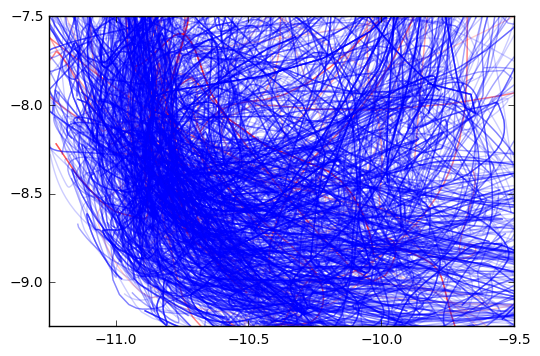

In [2]:
for i in range(iterations):
    if i % (iterations/10) == 0:
        print "Iteration", i
    context = environment.get_current_context()
    m = agent.produce(context)
    s = environment.update(m)
    agent.perceive(s)
    s_traj = environment.diva_traj
    if s_traj is not None:
        if i < 100:
            plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="r", alpha=0.2)
        else:
            plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="b", alpha=0.2)
            
plt.xlim([-11.25,-9.5])
plt.ylim([-9.25, -7.5])

error oiy 0.787985083408


(-9.25, -7.5)

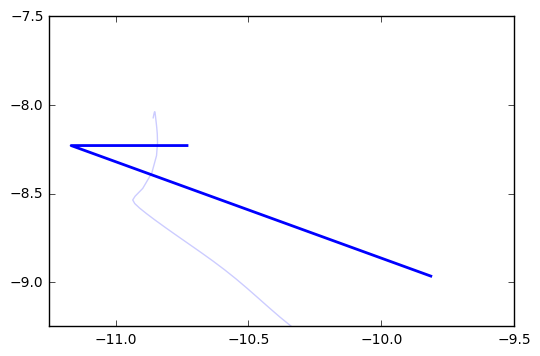

In [4]:
#for hs in human_sounds:
hs = "oiy"
agent.modules["mod13"].sm.sigma_expl = np.array([0.1]*28)
#print agent.modules["mod13"].sm.sigma_expl
m = agent.modules["mod13"].inverse(np.array(environment.human_sounds_traj_std[hs]), explore=True) 
#print m
s = environment.update([0.]*21 + list(m))
s_traj = environment.diva_traj
#print s_traj
error = np.linalg.norm(np.array(environment.human_sounds_traj[hs]) - np.array([f[0] for f in s_traj[[0, 12, 24, 37, 49]]] + [f[1] for f in s_traj[[0, 12, 24, 37, 49]]]))
print "error", hs, error


plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="b", alpha=0.2)    
plt.plot(- np.array(environment.human_sounds_traj[hs][5:]), -np.array(environment.human_sounds_traj[hs][:5]), lw=2)

plt.xlim([-11.25,-9.5])
plt.ylim([-9.25, -7.5])

In [3]:

for i in range(100):
    context = environment.get_current_context()[:4]
    s_goal = [2. * np.random.random() - 1. for _ in range(10)]

    m = agent.modules["mod10"].inverse(np.array(context + s_goal), explore=True)
    m = [0.] * 21 + list(m)
    s = environment.update(m)
    if environment.produced_sound:
        print environment.produced_sound
    agent.perceive(s)

In [3]:
print agent.modules["mod10"].sm.model.imodel.fmodel.dataset.data[1]

[]


In [10]:
# TEST EVAL
n_goals = 10

eval_results = {}

for region in [1, 2, 3]:        
    eval_results[region] = {}
    for i in range(n_goals):
        eval_results[region][i] = {}
        environment.reset_toys()
        for toy in ["toy1", "toy2", "toy3"]:
            eval_results[region][i][toy] = {}
                                    
            if toy == "toy1":
                goal = [environment.current_toy1[0] * (1. - t) for t in [0., 0.3, 0.5, 0.8, 1.]] + \
                       [environment.current_toy1[1] * (1. - t) for t in [0., 0.3, 0.5, 0.8, 1.]]
                arm_mid = "mod3"
                diva_mid = "mod10"
            elif toy == "toy2":
                goal = [environment.current_toy2[0] * (1. - t) for t in [0., 0.3, 0.5, 0.8, 1.]] + \
                       [environment.current_toy2[1] * (1. - t) for t in [0., 0.3, 0.5, 0.8, 1.]]
                arm_mid = "mod4"
                diva_mid = "mod11"
            elif toy == "toy3":
                goal = [environment.current_toy3[0] * (1. - t) for t in [0., 0.3, 0.5, 0.8, 1.]] + \
                       [environment.current_toy3[1] * (1. - t) for t in [0., 0.3, 0.5, 0.8, 1.]]
                arm_mid = "mod5"
                diva_mid = "mod12"
                
            context = list(agent.modules[arm_mid].get_c(environment.get_current_context()))
            dists, _ = agent.modules[arm_mid].sm.model.imodel.fmodel.dataset.nn_y(context+goal)
            arm_dist = dists[0]
            
            if len(agent.modules[diva_mid].sm.model.imodel.fmodel.dataset) > 0:
                context = list(agent.modules[diva_mid].get_c(environment.get_current_context()))
                dists, _ = agent.modules[diva_mid].sm.model.imodel.fmodel.dataset.nn_y(context+goal)
                diva_dist = dists[0]
            else:
                diva_dist = np.inf
            
            if arm_dist < diva_dist:
                m = agent.modules[arm_mid].inverse(np.array(context + goal), explore=False)            
                m = list(m) + [0.]*28
            else:
                m = agent.modules[diva_mid].inverse(np.array(context + goal), explore=False)            
                m = [0.]*21 + list(m)
                
            s = environment.update(m)
            
            if toy == "toy1":
                reached = s[30:40]
            elif toy == "toy2":
                reached = s[40:50]
            elif toy == "toy3":
                reached = s[50:60]
                
            comp_error = np.linalg.norm(np.array(reached) - np.array(goal))
            
            eval_results[region][i][toy]["comp_error"] = comp_error
            eval_results[region][i][toy]["arm_dist"] = arm_dist
            eval_results[region][i][toy]["diva_dist"] = diva_dist

In [11]:
print eval_results

{1: {0: {'toy1': {'comp_error': 2.0112510116968036, 'diva_dist': inf, 'arm_dist': 2.3457249350085694}, 'toy2': {'comp_error': 1.3587584670649857, 'diva_dist': inf, 'arm_dist': 2.0959802722687857}, 'toy3': {'comp_error': 0.83962648372889959, 'diva_dist': inf, 'arm_dist': 1.067479024620348}}, 1: {'toy1': {'comp_error': 0.61682910402519109, 'diva_dist': inf, 'arm_dist': 0.93724661873664306}, 'toy2': {'comp_error': 1.2557097513243816, 'diva_dist': inf, 'arm_dist': 2.1249736656206091}, 'toy3': {'comp_error': 1.1683655917824638, 'diva_dist': inf, 'arm_dist': 1.853937545371928}}, 2: {'toy1': {'comp_error': 0.83000389630299343, 'diva_dist': inf, 'arm_dist': 1.0404701259740263}, 'toy2': {'comp_error': 0.23034725196923253, 'diva_dist': inf, 'arm_dist': 0.45640730499320403}, 'toy3': {'comp_error': 0.86429945780649498, 'diva_dist': inf, 'arm_dist': 0.99413912480418676}}, 3: {'toy1': {'comp_error': 1.0880989139179567, 'diva_dist': inf, 'arm_dist': 1.4539604993783701}, 'toy2': {'comp_error': 0.65195